In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
from itertools import cycle
from sklearn.svm import SVC

# Load demo data

data_dir = '/media/garlicseed/data2/Schizophrenia'
data = pd.read_csv(f'{data_dir}/train.tsv',sep='\t')

# Load graph measures (example of loading one, repeat for others)

g1 = pd.read_pickle(f'{data_dir}/feature_train/G1_feature.pkl')
g2 = pd.read_pickle(f'{data_dir}/feature_train/G2_feature.pkl')
GV = pd.read_pickle(f'{data_dir}/feature_train/GV_feature.pkl')
Curv = pd.read_pickle(f'{data_dir}/feature_train/Gaussian_Curvature_feature.pkl')
Thickness = pd.read_pickle(f'{data_dir}/feature_train/Thickness_feature.pkl')
GD = pd.read_pickle(f'{data_dir}/feature_train/Geodesic_distance_feature.pkl') 

# Stack the topo measures
comprehensive_measures = pd.concat([g1, g2,GV,Curv,Thickness,GD], axis=1)
# Combine with demo data
#features = pd.concat([data[['group']], topo_measures], axis=1)
annot = pd.read_csv(f"/media/garlicseed/data2/Schizophrenia/integration/material/schaefer_400_label.csv")
annot['StructName'] = annot['StructName'].str.replace("7Networks_", "", regex=False)
annot['StructName'] = annot['StructName'].replace({
    'LH_': 'L_', 'RH_': 'R_', 'DorsAttn': 'DA', 'Default': 'DF', 'SalVentAttn': 'SVA',
    'Limbic': 'LB', 'Cont': 'CON', 'SomMot': 'SM', 'Vis': 'VS'
}, regex=True)
roi_labels = annot['StructName'].values

# Prepare model matrix
X = comprehensive_measures

#处理索引
region_labels = X.columns.get_level_values('Region_Label')
networks = X.columns.get_level_values('Network')
modalities = X.columns.get_level_values('Modality')
types = X.columns.get_level_values('label')
region_x = X.columns.get_level_values('region')
column_info = {
    'region_labels': region_labels,
    'networks': networks,
    'modalities': modalities,
    'types':types,
    'regions':region_x
}
X.columns = region_labels

y1 = data['diagnosis'].astype('category')
from sklearn.model_selection import train_test_split, GridSearchCV
# Split data into train/test
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
encoder = LabelEncoder()
y = encoder.fit_transform(y1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)
scaler = StandardScaler()
encoder = LabelEncoder()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [3]:
#ROC
#import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
#from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm_notebook

# XGBoost模型参数
params_xgb = {
    'learning_rate': 0.02,
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'max_leaves': 127,
    'verbosity': 1,
    'seed': 42,
    'nthread': -1,
    'colsample_bytree': 0.6,
    'subsample': 0.7,
    'n_estimators': 200,  # 固定树的数量
    'max_depth': 4,       # 固定树的深度
    'min_child_weight': 1 # 固定节点最小权重
}

# Define models
models_dict = {
    "RandomForest": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42,max_depth=10 , max_features = 'log2', n_estimators = 100,
                                             min_samples_split = 2, min_samples_leaf = 2))
    ]),
    "GradientBoosting": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GradientBoostingClassifier(random_state=42,learning_rate = 0.2, max_depth = 7, n_estimators = 200, subsample = 0.8))
    ]),
    "LightGBM": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LGBMClassifier(random_state=42, verbose=-1))
    ]),
    "CatBoost": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', CatBoostClassifier(verbose=0, random_state=42,depth = 6,iterations = 100, learning_rate =0.05))
    ]),
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(kernel='linear', probability=True, max_iter=10000, class_weight='balanced', C=0.001, gamma=0.0001, random_state=42))
    ])
}


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
model_results = {}
# Cross-validation loop
for model_name, model in tqdm_notebook(models_dict.items()):
    fold_roc_data = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_train_scaled, y_train)):
        # Split data into train and test
        X_train_fold, X_test_fold = X_train_scaled.values[train_idx], X_train_scaled.values[test_idx]
        y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Get predicted probabilities
        y_proba = model.predict_proba(X_test_fold)[:, 1]

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
        roc_auc = auc(fpr, tpr)

        # Save the fold ROC data
        fold_roc_data.append(pd.DataFrame({
            'fold': fold_idx + 1,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'model': model_name
        }))
    
    # Concatenate fold ROC data for the current model
    model_results[model_name] = pd.concat(fold_roc_data, ignore_index=True)

/tmp/ipykernel_85807/1160385448.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model in tqdm_notebook(models_dict.items()):


  0%|          | 0/5 [00:00<?, ?it/s]

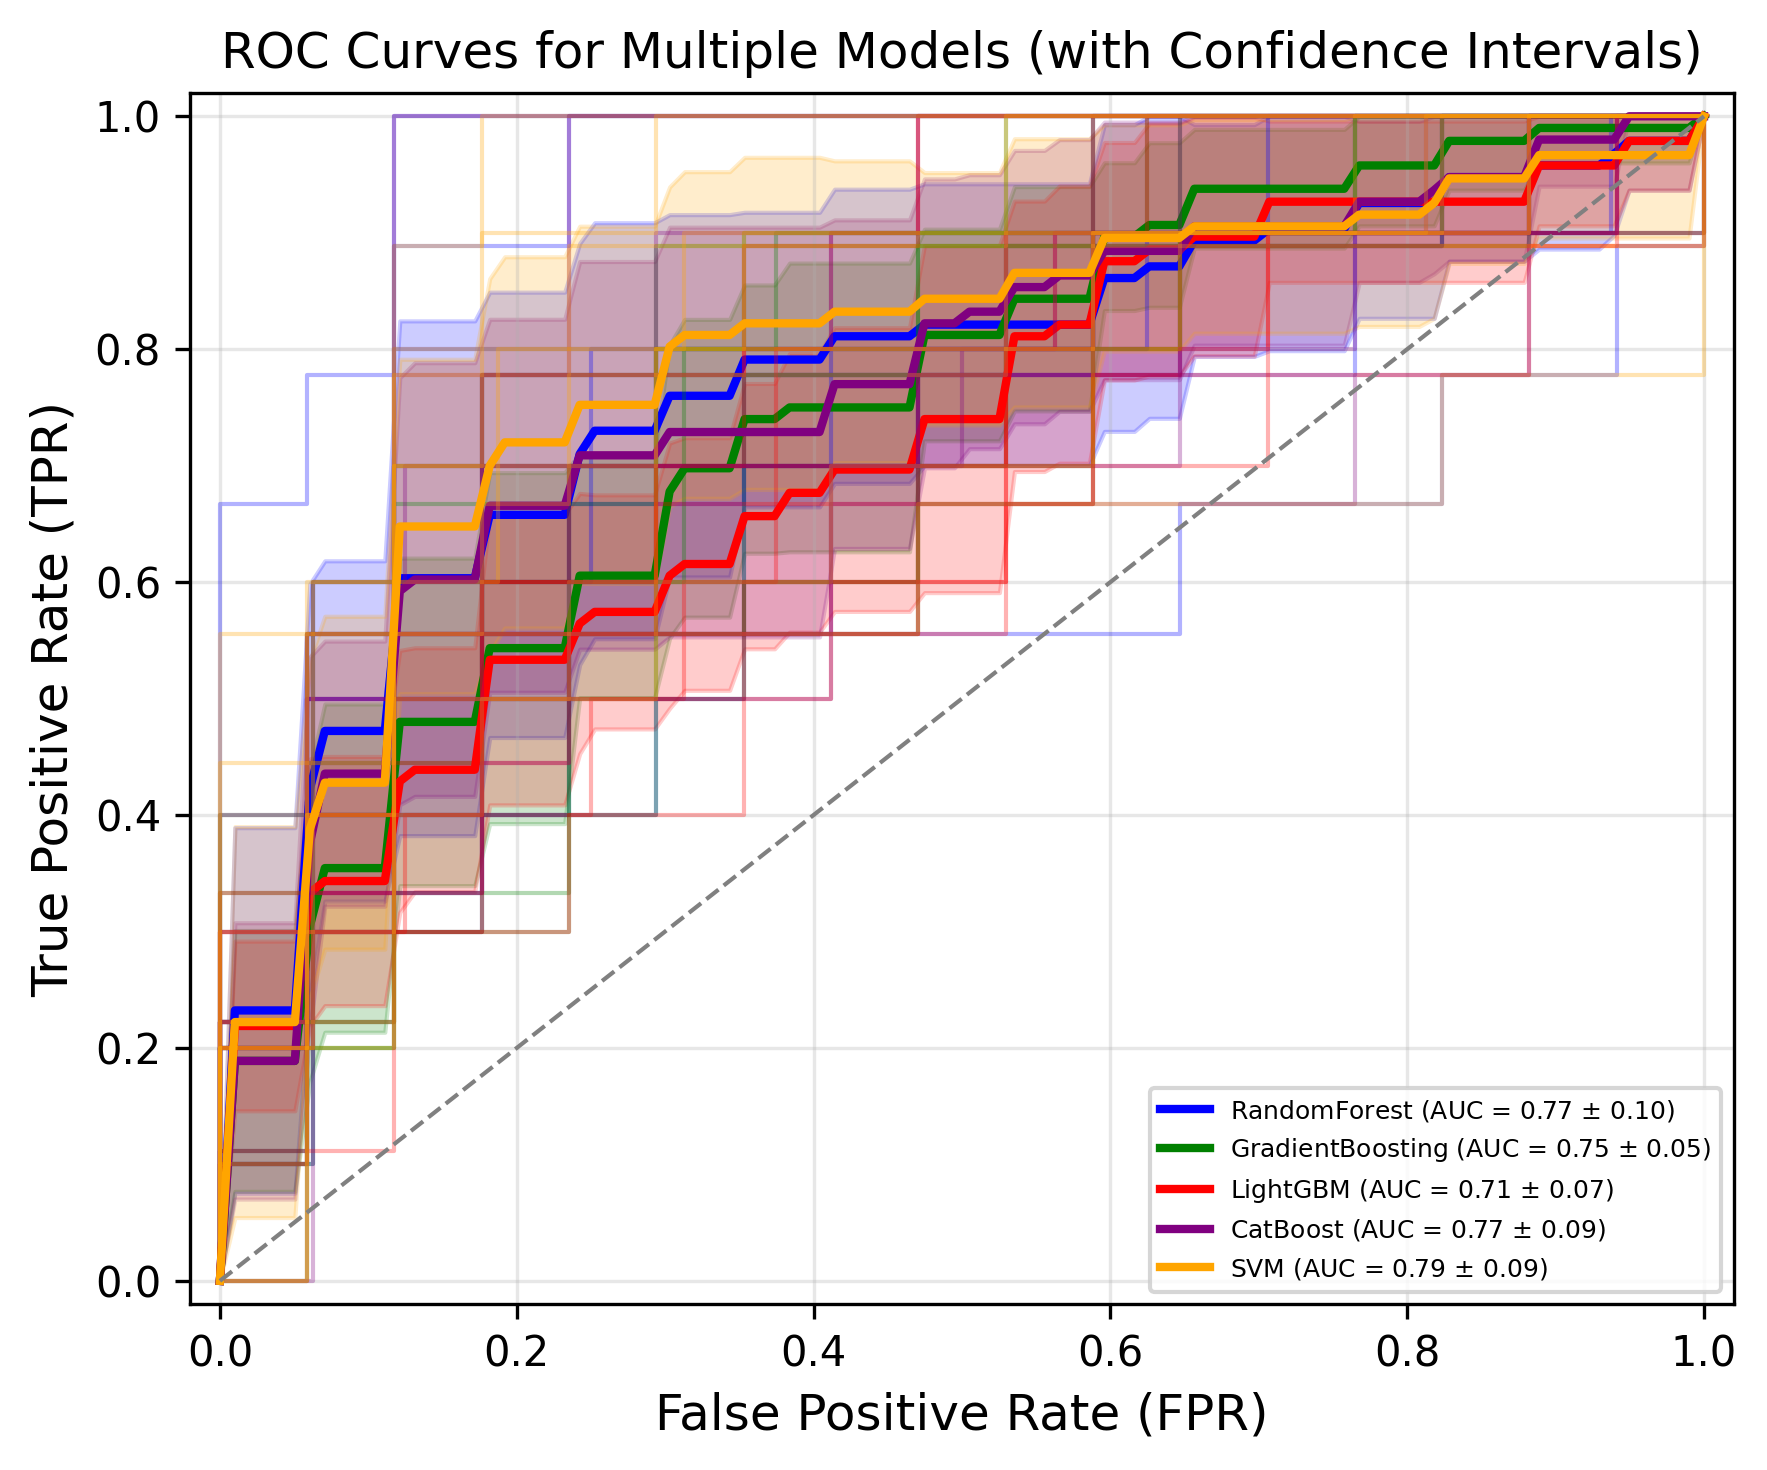

In [4]:
#ROC
import numpy as np
import matplotlib.pyplot as plt

# Set up plot
plt.figure(figsize=(6, 5), dpi=300)

# Interpolation grid
mean_fpr = np.linspace(0, 1, 100)

# Color map for models
colors = {
    'RandomForest': 'blue',
    'GradientBoosting': 'green',
    'LightGBM': 'red',
    'CatBoost': 'purple',
    'SVM': 'orange'
}

# Loop through each model and plot its ROC curve
for model_name, roc_data_df in model_results.items():
    tprs = []
    
    # Plot individual fold ROC curves for each model
    for fold in roc_data_df['fold'].unique():
        fold_data = roc_data_df[roc_data_df['fold'] == fold]
        interp_tpr = np.interp(mean_fpr, fold_data['fpr'], fold_data['tpr'])  # Interpolation
        interp_tpr[0] = 0.0  # Ensure starting point is 0
        tprs.append(interp_tpr)
        plt.plot(fold_data['fpr'], fold_data['tpr'], color=colors[model_name], alpha=0.3, lw=1, label=None)

    # Calculate mean and standard deviation of TPR (True Positive Rate)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # Ensure endpoint is 1
    std_tpr = np.std(tprs, axis=0)

    # Calculate the mean AUC and standard deviation of AUC for the model
    aucs = roc_data_df.groupby('fold')['roc_auc'].first().values  # Extract AUC for each fold
    mean_auc = np.mean(aucs)  # Mean AUC
    std_auc = np.std(aucs)    # Standard deviation of AUC

    # Plot the mean ROC curve for the model
    plt.plot(mean_fpr, mean_tpr, alpha=1.0, lw=2, color=colors[model_name], label=f'{model_name} (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})')

    # Plot the confidence interval (1 std dev) around the mean ROC curve
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[model_name], alpha=0.2)

# Add the diagonal line (chance level)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# Set plot limits and labels
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curves for Multiple Models (with Confidence Intervals)', fontsize=12)

# Add legend
plt.legend(loc="lower right", fontsize=6)

# Display grid
plt.grid(alpha=0.3)
plt.tight_layout()
# Save the plot as a PDF
#plt.savefig("roc_curves_multiple_models.pdf", format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

In [5]:
# circular barplot
# 随机森林
rf_model = RandomForestClassifier(random_state=42,max_depth=10 , max_features = 'log2', n_estimators = 100,
                                             min_samples_split = 2, min_samples_leaf = 2)
rf_model.fit(X_train_scaled, y_train)

# 梯度提升
gb_model = GradientBoostingClassifier(random_state=42,learning_rate = 0.2, max_depth = 7, n_estimators = 200, subsample = 0.8)
gb_model.fit(X_train_scaled, y_train)

# LightGBM
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)
lgbm_model.fit(X_train_scaled, y_train)

# CatBoost
catboost_model = CatBoostClassifier(verbose=0, random_state=42,depth = 6,iterations = 100, learning_rate =0.05)
catboost_model.fit(X_train_scaled, y_train)

#SVM
svc_model = SVC(kernel='linear', probability=True, max_iter=10000, class_weight='balanced', C=0.001, gamma=0.0001)
svc_model.fit(X_train_scaled, y_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# 初始化结果存储
results = []

# 定义函数计算并保存指标
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr') if y_prob is not None else np.nan

    # 存储结果
    results.append({
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "ROC-AUC": roc_auc,
        "Model": model_name
    })

# 评估每个模型
evaluate_model("RF", rf_model, X_test_scaled, y_test)
evaluate_model("GBM", gb_model, X_test_scaled, y_test)
evaluate_model("SVC", svc_model, X_test_scaled, y_test)
evaluate_model("LightGBM", lgbm_model, X_test_scaled, y_test)
evaluate_model("CatBoost", catboost_model, X_test_scaled, y_test)
results_df = pd.DataFrame(results)
results_df

,Accuracy,Precision,Recall,F1-score,ROC-AUC,Model
0,0.761194,0.759438,0.761194,0.747475,0.805233,RF
1,0.791045,0.794410,0.791045,0.779041,0.785853,GBM
2,0.791045,0.791045,0.791045,0.791045,0.833333,SVC
3,0.865672,0.868699,0.865672,0.861552,0.843992,LightGBM
4,0.805970,0.816475,0.805970,0.792773,0.815891,CatBoost


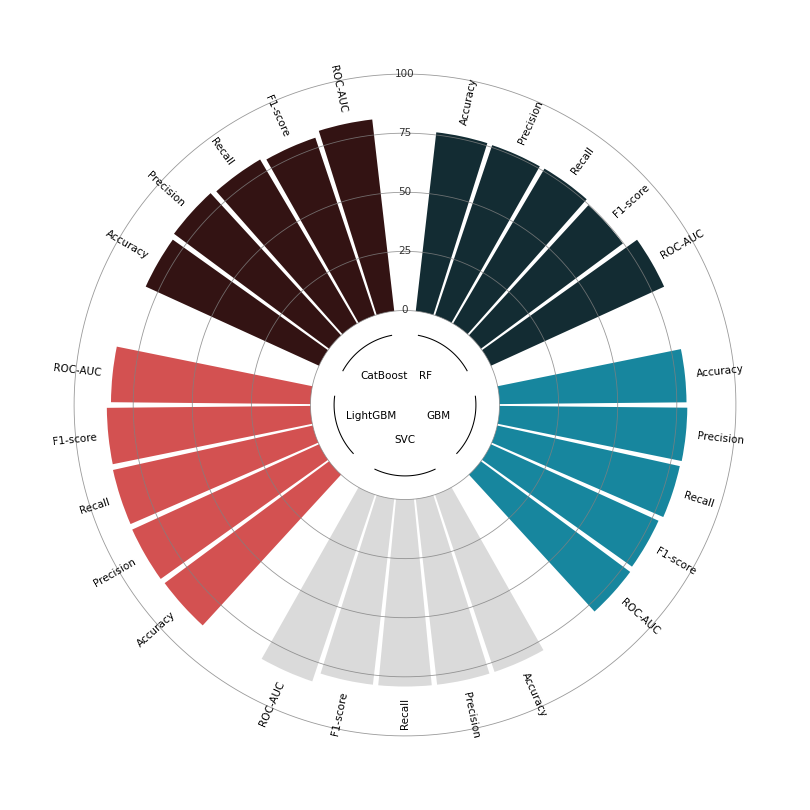

In [8]:
# circular barplot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'results' is a list of dictionaries from the evaluate_model function.
# Convert the results into a DataFrame
groups = results_df.set_index('Model').T.to_numpy() * 100

# Define the group names (metrics)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
group_names = ['RF', 'GBM', 'SVC', 'LightGBM', 'CatBoost']  # Shortened metric names
model_names = results_df['Model'].unique()
group_colors = ["#132C33", '#17869E', '#DADADA', '#D35151', '#331313']

# Plot
fig = plt.figure(figsize=(5.5, 5.5), dpi=150, facecolor='white')
ax = fig.add_subplot(projection='polar')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# 初始化 bar 图的参数
radii = [0]
colors = ['white']

# 将组数据转换为 bar 的半径和颜色
for g, c in zip(groups.T, group_colors):
    radii.extend(g)
    colors.extend([c] * len(g))
    radii.append(0)
    colors.append('white')
radii.pop()
colors.pop()

# 定义极坐标参数
N = len(radii)
scale_lim = 100
scale_major = 25
bottom = 40
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
width = 2 * np.pi / (N + 3)

# 绘制 bar 图
ax.bar(theta, radii, width=width, bottom=bottom, color=colors)

# 定义完整的刻度线函数
def scale_full(ax, bottom, scale_lim, scale_major):
    for i in range(int(bottom), int(bottom + scale_lim + scale_major), scale_major):
        ax.plot(
            np.linspace(0, 2 * np.pi, 500),  # 全圆刻度
            [i] * 500,  # 半径
            linewidth=0.4,
            color='gray',
            alpha=0.8
        )

# 定义刻度值函数
def scale_value(ax, bottom, theta, scale_lim):
    for i in range(int(bottom), int(bottom + scale_lim + scale_major), scale_major):
        ax.text(
            theta,
            i,
            f'{i - bottom}',
            fontsize=5,
            alpha=0.8,
            va='center',
            ha='center'
        )

# 绘制完整刻度线
scale_full(ax, bottom, scale_lim, scale_major)

# 在顶部绘制刻度值
scale_value(ax, bottom, 0, scale_lim)

# 分组分隔和标签
s_list = []
g_no = 0

# 循环绘制 bar 标签
for t, r in zip(theta, radii):
    if r == 0:
        s_list.append(t)
    else:
        t2 = np.rad2deg(t)
        ax.text(
            t, r + bottom + scale_major * 0.2,
            metrics[g_no],
            fontsize=5,
            rotation=90 - t2 if t < np.pi else 270 - t2,
            rotation_mode='anchor',
            va='center',
            ha='left' if t < np.pi else 'right',
            color='black',
            clip_on=False
        )
        if g_no == (len(metrics) - 1):
            g_no = 0
        else:
            g_no += 1
s_list.append(2 * np.pi)

# 为每组添加分隔线和组名
for i in range(len(s_list) - 1):
    t = np.linspace(s_list[i] + width, s_list[i + 1] - width, 50)
    ax.plot(t, [bottom - scale_major * 0.4] * 50, linewidth=0.5, color='black')
    ax.text(
        s_list[i] + (s_list[i + 1] - s_list[i]) / 2,
        bottom - scale_major * 1.0,
        group_names[i],
        va='center',
        ha='center',
        fontsize=5,
    )

# 设置径向范围和隐藏坐标轴
ax.set_rlim(0, bottom + scale_lim + scale_major)
ax.axis('off')

# 调整布局并显示图形
plt.tight_layout()
# Show the plot
plt.show()


In [19]:
#shap feature
import shap
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
#from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm_notebook


rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
print('rf_model....')
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)
print('gb_model....')
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)
lgbm_model.fit(X_train_scaled, y_train)
print('lgbm_model....')
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X_train_scaled, y_train)
print('catboost_model....')
svm_model = SVC(kernel='linear', probability=True, max_iter=10000, class_weight='balanced', C=0.001, gamma=0.0001, random_state=42)
svm_model.fit(X_train_scaled, y_train)
print('svm_model....')


# 随机森林 SHAP 值计算
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer(X_train_scaled)
rf_shap_df = pd.DataFrame(rf_shap_values[:,:,0].values, columns=X_train.columns)
print('shap for rf_model....')
# 梯度提升 SHAP 值计算
gb_explainer = shap.TreeExplainer(gb_model)
gb_shap_values = gb_explainer(X_train_scaled)
gb_shap_df = pd.DataFrame(gb_shap_values.values, columns=X_train.columns)
print('shap for gb_model....')
# XGBoost SHAP 值计算
#xgb_explainer = shap.TreeExplainer(xgb_model)
#xgb_shap_values = xgb_explainer(X_train)
#xgb_shap_df = pd.DataFrame(xgb_shap_values.values, columns=X_train.columns)
# LightGBM SHAP 值计算
lgbm_explainer = shap.TreeExplainer(lgbm_model)
lgbm_shap_values = lgbm_explainer(X_train_scaled)
lgbm_shap_df = pd.DataFrame(lgbm_shap_values[:,:,0].values, columns=X_train.columns)
print('shap for lgbm_model....')
# CatBoost SHAP 值计算
catboost_explainer = shap.Explainer(catboost_model, X_train_scaled, feature_names=X_train.columns)
catboost_shap_values = catboost_explainer(X_train_scaled)
catboost_shap_df = pd.DataFrame(catboost_shap_values.values, columns=X_train.columns)
print('shap for catboost_model....')

# svm SHAP 值计算
svm_explainer = shap.Explainer(svm_model, X_train_scaled, feature_names=X_train.columns)
svm_shap_values = svm_explainer(X_train_scaled)
svm_shap_df = pd.DataFrame(svm_shap_values.values, columns=X_train.columns)
print('shap for svm_model....')

rf_model....
gb_model....
lgbm_model....
catboost_model....
svm_model....
shap for rf_model....
shap for gb_model....
shap for lgbm_model....


 95%|=================== | 251/265 [00:14<00:00]       

shap for catboost_model....
shap for svm_model....


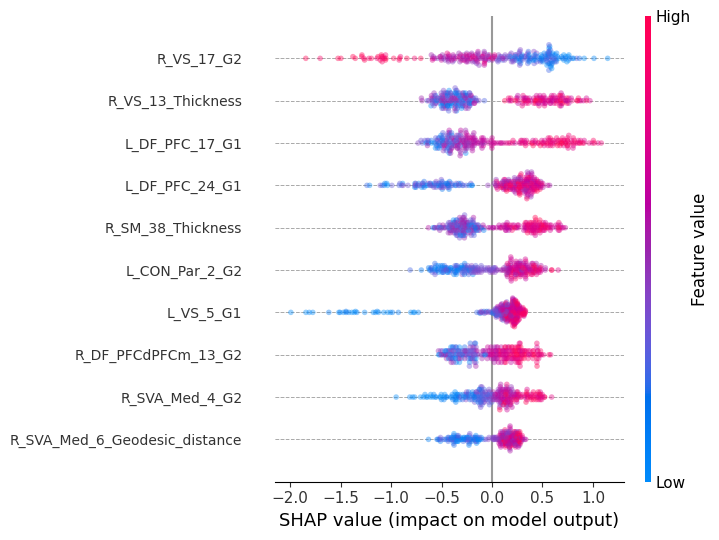

In [23]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# 创建新的绘图对象，设置图形大小和dpi
fig, ax = plt.subplots()

# 绘制SHAP总结图，暂时不显示
shap.summary_plot(lgbm_shap_values[:,:,0], X_train_scaled, alpha=0.4, max_display=10, show=False)

# 更改y轴标签的字体大小
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

# 更改背景虚线的颜色
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, color='darkgray')

# 显示图形
plt.show()


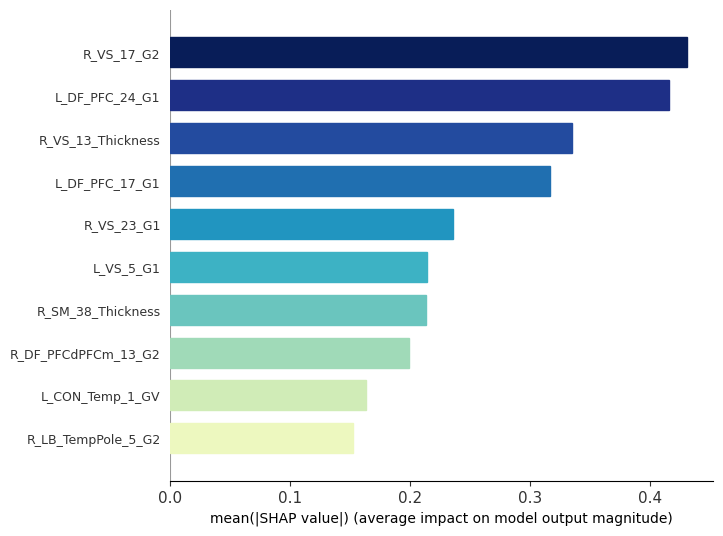

In [24]:
import shap
import matplotlib.pyplot as plt
import numpy as np
colorbar_colors = [ '#EDF8BFFF', '#C7E9B4FF', '#7FCDBBFF', 
          '#41B6C4FF', '#1D91C0FF', '#225EA8FF', '#253494FF', '#081D58FF']

from matplotlib.colors import LinearSegmentedColormap

# Create a custom linear colormap
continuous_cmap = LinearSegmentedColormap.from_list("continuous", colorbar_colors)

fig, ax = plt.subplots(dpi=100)
shap.summary_plot(gb_shap_values, X_train_scaled, plot_type="bar", alpha=0.4, max_display=10, show=False)

cmap = plt.get_cmap(continuous_cmap)  
bars = ax.patches
for bar, color in zip(bars, cmap(np.linspace(0, 1, len(bars)))):
    bar.set_color(color)

# 修改左边标签和标题的字体大小
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
ax.set_xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontsize=10)
# 显示图形
plt.show()

In [15]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm_notebook
# 获取 SHAP 特征排名
# rf_shap_df 等是模型对应的 SHAP 值，计算特征重要性排名
shap_feature_importances = {
    "RandomForest": np.abs(rf_shap_df).mean().sort_values(ascending=False).index.tolist(),
    "GradientBoosting": np.abs(gb_shap_df).mean().sort_values(ascending=False).index.tolist(),
    "LightGBM": np.abs(lgbm_shap_df).mean().sort_values(ascending=False).index.tolist(),
    "CatBoost": np.abs(catboost_shap_df).mean().sort_values(ascending=False).index.tolist(),
    "SVM": np.abs(svm_shap_df).mean().sort_values(ascending=False).index.tolist()
}

models_init = {
    "RandomForest": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]),
    "LightGBM": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LGBMClassifier(random_state=42, verbose=-1))
    ]),
    "CatBoost": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', CatBoostClassifier(verbose=0, random_state=42))
    ]),
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', SVC(kernel='linear', probability=True, max_iter=10000, class_weight='balanced', C=0.001, gamma=0.0001, random_state=42))
    ])
}

# 创建保存结果的 DataFrame
results = []

# 递归特征选择并训练模型
for num_features in tqdm_notebook(range(1, len(X_train.columns) + 1)):  # 从1到所有特征
    row = {"Number_of_Features": num_features}
    
    # 遍历每个模型
    for model_name, model_init in models_init.items():
        try:
            # 获取当前模型的特征排名
            top_features = shap_feature_importances[model_name][:num_features]
            
            # 使用这些特征重新训练模型
            X_train_subset = X_train[top_features]
            X_test_subset = X_test[top_features]
            
            # 重新初始化并训练模型
            model = model_init
            model.fit(X_train_subset, y_train)
            
            # 在测试集上预测并计算 AUC
            if hasattr(model, "predict_proba"):
                y_pred = model.predict_proba(X_test_subset)[:, 1]  # 获取预测概率
            else:
                y_pred = model.predict(X_test_subset)  # 如果没有 `predict_proba`，直接用预测值
            
            auc_score = roc_auc_score(y_test, y_pred)  # 计算AUC
        except Exception as e:
            print(f"Error for model {model_name} with {num_features} features: {e}")
            auc_score = np.nan  # 如果出现问题，设置为NaN
        
        row[model_name] = auc_score  # 保存AUC值
    
    # 保存每次特征选择的结果
    results.append(row)

results_features = pd.DataFrame(results)
results_features

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/114 [00:00<?, ?it/s]

,Number_of_Features,RandomForest,GradientBoosting,LightGBM,CatBoost,SVM
0,1,0.671512,0.601744,0.707849,0.627422,0.317829
1,2,0.690407,0.727229,0.695252,0.592054,0.309109
2,3,0.653101,0.748062,0.807171,0.620155,0.645349
3,4,0.714147,0.748062,0.797481,0.732558,0.677326
4,5,0.672481,0.749031,0.745155,0.765504,0.720930
...,...,...,...,...,...,...
109,110,0.835271,0.793605,0.815891,0.803295,0.836240
110,111,0.875000,0.786822,0.817829,0.825581,0.836240
111,112,0.851260,0.795543,0.821705,0.835271,0.836240
112,113,0.812016,0.765504,0.844961,0.818798,0.836240


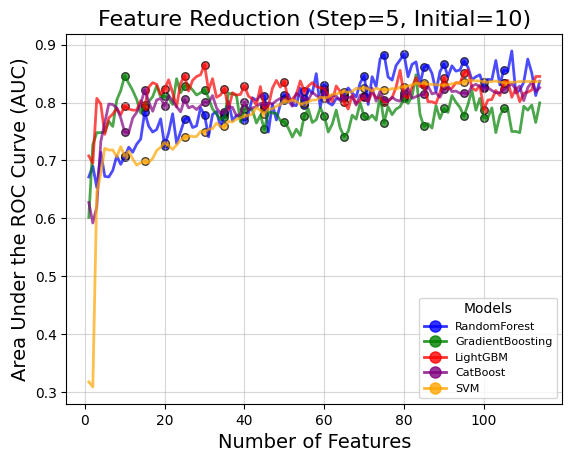

In [17]:
# shap-based RFE feature selection
import matplotlib.pyplot as plt

num_features = list(range(10, 110, 5))  # 从20开始，每隔100步

colors = {
    'RandomForest': 'blue',
    'GradientBoosting': 'green',
    'LightGBM': 'red',
    'CatBoost': 'purple',
    'SVM': 'orange'
}

for model in colors.keys():
    plt.plot(
        results_features['Number_of_Features'], 
        results_features[model], 
        label=model, 
        color=colors[model], 
        linewidth=2,  
        alpha=0.7     
    )
    
    subset_df = results_features[results_features['Number_of_Features'].isin(num_features)]
    plt.scatter(
        subset_df['Number_of_Features'], 
        subset_df[model], 
        color=colors[model], 
        s=30,        
        alpha=0.7,  
        edgecolor='black'
    )

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=colors[model], marker='o', markersize=8, linewidth=2, alpha=0.8, label=model)
    for model in colors.keys()
]
plt.legend(handles=legend_elements, title="Models", fontsize=8, loc="lower right")
plt.title("Feature Reduction (Step=5, Initial=10)", fontsize=16)
plt.xlabel("Number of Features", fontsize=14)
plt.ylabel("Area Under the ROC Curve (AUC)", fontsize=14)
plt.grid(alpha=0.5)
plt.show()


In [54]:
column_mapping = {}
for i, region in enumerate(region_labels):
    column_mapping[region] = (region, networks[i], modalities[i],types[i],region_x[i])

# 获取SHAP值最大的前20个特征的索引
top_20_features = lgbm_shap_df.abs().mean().nlargest(25).index

# 创建一个包含完整信息的结果DataFrame
feature_index = pd.DataFrame({
    'Region_Label': [column_mapping[feature][0] for feature in top_20_features],
    'Network': [column_mapping[feature][1] for feature in top_20_features],
    'Modality': [column_mapping[feature][2] for feature in top_20_features],
    'Type': [column_mapping[feature][3] for feature in top_20_features],
    'Region':[column_mapping[feature][4] for feature in top_20_features],
    'SHAP_Value': [lgbm_shap_df[feature].mean() for feature in top_20_features]
})

# 按SHAP值绝对值排序
feature_index = feature_index.reindex(feature_index['SHAP_Value'].abs().sort_values(ascending=False).index)

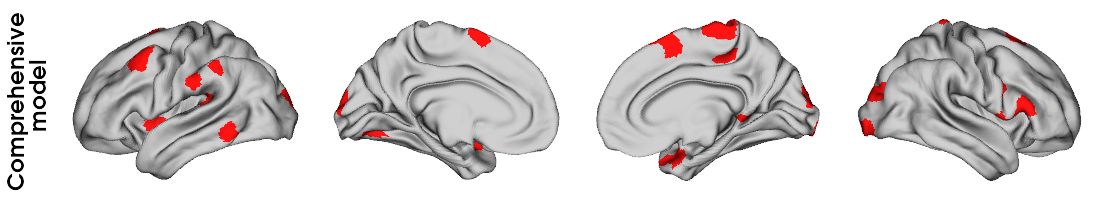

In [55]:
from brainspace.mesh.mesh_io import read_surface
subj_dir = '/media/garlicseed/data2/Schizophrenia/derivate/micapipe_v0.2.0/'
atlas='schaefer-400' 
micapipe='/media/garlicseed/data2/Schizophrenia' # <<<<<<<<<<<< CHANGE THIS PATH
# Load fsLR-32k
f32k_lh = read_surface(f'{micapipe}/surfaces/fsLR-32k.L.surf.gii', itype='gii')
f32k_rh = read_surface(f'{micapipe}/surfaces/fsLR-32k.R.surf.gii', itype='gii')

import numpy as np

# 提取前10个特征名称
top_10_features = feature_index['Region'].values

# 创建一个全零序列
feature_sequence = np.zeros(400)
feature_sequence[:] = np.nan

# 查找每个特征在 annot['StructName'] 中的位置，并将对应的 zero_sequence 位置改为 1
for feature in top_10_features:
    # 直接与annot['StructName']中的标签完全匹配
    matching_indices = annot[annot['StructName'] == feature].index  # 精确匹配

    # 将对应的位置设置为1
    feature_sequence[matching_indices] = 1

    
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_parcellation
labeling = load_parcellation('schaefer', scale=400, join=True)
mask = labeling != 0
mapp = map_to_labels(feature_sequence, labeling, mask=mask, fill=np.nan)
label_text = ['Comprehensive \n model']
plot_hemispheres(f32k_lh, f32k_rh, mapp, color_bar=False,
        label_text=label_text, cmap="autumn", embed_nb=True, size=(1100, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 6}, interactive=False, layout_style = 'row')

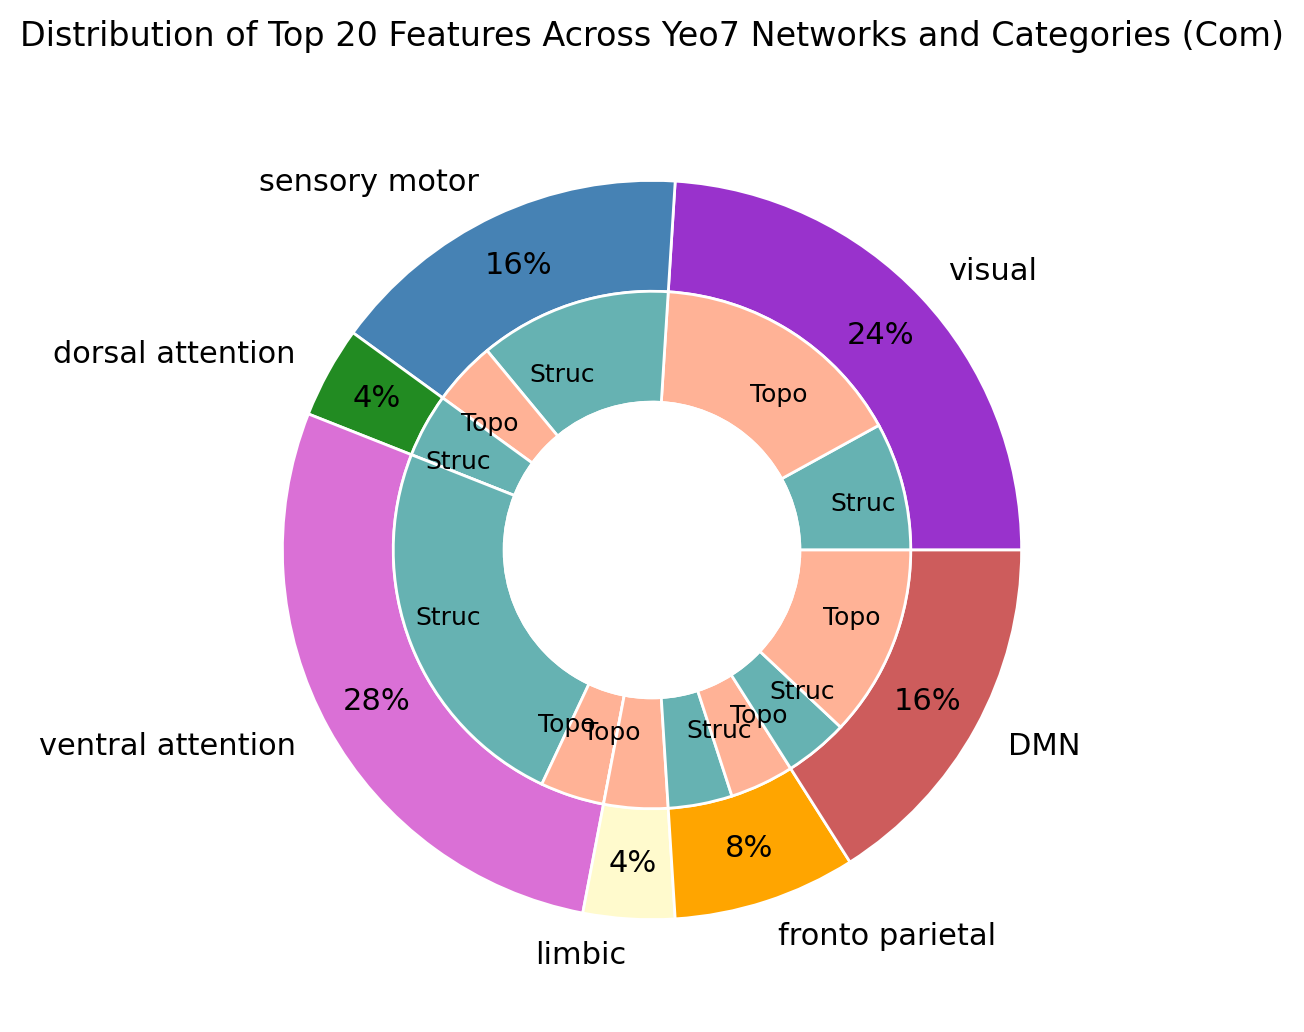

In [59]:
from matplotlib.colors import ListedColormap

# define custom colormap using color names (in order of corresponding networks: 1 visual, 2 sensorimotor, 3 dorsal attention, 4 ventral attention, 5 limbic, 6 fronto parietal, 7 DMN)
colors_yeo7 = ['darkorchid', 'steelblue', 'forestgreen', 'orchid', 'lemonchiffon', 'orange',  'indianred']

yeo7_colormap = ListedColormap(colors_yeo7, 'custom_colormap')

yeo7_colormap
from brainspace.mesh.mesh_io import read_surface
subj_dir = '/media/garlicseed/data2/Schizophrenia/derivate/micapipe_v0.2.0/'
atlas='schaefer-400' 
micapipe='/media/garlicseed/data2/Schizophrenia' # <<<<<<<<<<<< CHANGE THIS PATH
# Load fsLR-32k
f32k_lh = read_surface(f'{micapipe}/surfaces/fsLR-32k.L.surf.gii', itype='gii')
f32k_rh = read_surface(f'{micapipe}/surfaces/fsLR-32k.R.surf.gii', itype='gii')

yeo7_networks_array = np.genfromtxt('/media/garlicseed/data2/Schizophrenia/surfaces/schaefer400x7CommunityAffiliation.1D', delimiter=',', skip_header=0)
# original Yeo network colors
palette_labeled_networks = {'DMN': 'indianred',  
                            'dorsal attention' : 'forestgreen',  
                            'fronto parietal' : 'orange',  
                            'limbic' : 'lemonchiffon',  
                            'sensory motor' : 'steelblue',
                            'ventral attention' : 'orchid', 
                            'visual' : 'darkorchid'} 
# making an array with yeo network labels (names instead of numbers)
yeo7_networks_array_labels = []

for i in yeo7_networks_array:
    if i == 1:
        yeo7_networks_array_labels.append('visual')
    elif i == 2:
        yeo7_networks_array_labels.append('sensory motor')
    elif i == 3:
        yeo7_networks_array_labels.append('dorsal attention')
    elif i == 4:
        yeo7_networks_array_labels.append('ventral attention')
    elif i == 5:
        yeo7_networks_array_labels.append('limbic')
    elif i == 6:
        yeo7_networks_array_labels.append('fronto parietal')
    elif i == 7:
        yeo7_networks_array_labels.append('DMN')

yeo7_networks_array_labels = np.asarray(yeo7_networks_array_labels)
network_names = ["visual", "sensory motor", "dorsal attention", "ventral attention", "limbic", "fronto parietal", "DMN"]



# Initialize a count dictionary for each network
network_counts = {network: [0, 0] for network in network_names} 

# 遍历特征，统计每个网络的 struc 和 topo 比例
for _, row in feature_index.iterrows():
    feature = row['Region']
    feature_type = row['Modality']
    
    # 获取特征所属网络
    feature_network = yeo7_networks_array[np.where(roi_labels == feature)[0][0]]  # 找到网络索引
    network_label = network_names[int(feature_network) - 1]  # 转换网络索引为名称

    # 更新对应网络的计数
    if feature_type == 'STRUC':
        network_counts[network_label][0] += 1
    elif feature_type == 'TOPO':
        network_counts[network_label][1] += 1
        

filtered_network_counts = {k: v for k, v in network_counts.items() if sum(v) > 0}
# 提取网络名称、struc 和 topo 的计数
labels = list(filtered_network_counts.keys())
struc_counts = [counts[0] for counts in filtered_network_counts.values()]
topo_counts = [counts[1] for counts in filtered_network_counts.values()]

# 准备绘图数据
vals = np.array([struc_counts, topo_counts])
outer_sizes = vals.sum(axis=0)

inner_vals = []
for i in range(len(labels)):
    inner_vals.extend([struc_counts[i], topo_counts[i]])

# 定义颜色
outer_colors = [palette_labeled_networks[network] for network in labels]
outer_colors = outer_colors[:len(labels)]  # 确保颜色数量匹配
inner_colors = ['#008080', '#FF7F50'] * len(labels)  # 内层颜色：struc 和 topo

# 绘制嵌套圆环图
fig, ax = plt.subplots(figsize=(8, 6),dpi=200)
size = 0.3

# 外层饼图
ax.pie(outer_sizes, radius=1, labels=labels, colors=outer_colors, autopct='%.0f%%', pctdistance=0.85,
       wedgeprops=dict(width=size, edgecolor='white'), textprops={'fontsize': 11})

# 创建内层标签
inner_labels = []
for network in filtered_network_counts.values():
    # 对每个网络的struc
    if network[0] > 0:
        inner_labels.append('Struc')
    else:
        inner_labels.append('')
    # 对每个网络的topo
    if network[1] > 0:
        inner_labels.append('Topo')
    else:
        inner_labels.append('')

# 为inner_colors添加透明度
inner_colors_with_alpha = []
for color in inner_colors:
    # 如果颜色是以十六进制格式提供的，转换为RGBA
    if isinstance(color, str) and color.startswith('#'):
        from matplotlib.colors import to_rgba
        # 0.7是透明度值，可以根据需要调整(0-1之间，0完全透明，1完全不透明)
        inner_colors_with_alpha.append(to_rgba(color, alpha=0.6))
    else:
        # 如果已经是RGBA格式，直接调整alpha值
        r, g, b, a = to_rgba(color)
        inner_colors_with_alpha.append((r, g, b, 0.6))

inner_sizes = vals.flatten()
ax.pie(inner_vals, radius=1-size, labels=inner_labels, colors=inner_colors_with_alpha, 
       wedgeprops=dict(width=size, edgecolor='white'),  textprops={'fontsize': 9},  labeldistance=0.71)

# 中心绘制白圈
my_circle = plt.Circle((0, 0), 0.4, color='white')
ax.add_artist(my_circle)

# 设置标题和显示
ax.set(aspect="equal")

# Set title
plt.title("Distribution of Top 20 Features Across Yeo7 Networks and Categories (Com)", fontsize=12,verticalalignment='bottom', y=1.02)
plt.savefig("/media/garlicseed/data2/Schizophrenia/integration/Figures/TOP_10_features_pie_com.svg", dpi=300)
plt.show()